In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
np.random.seed(12)

# Example 1: iSDR order 1

In [30]:
n_t = 150
n_c, n_s = 3,3
np.random.seed(40)
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
J = np.zeros((n_s, n_t))
J[:, 0] = [10, 0.1, 0]
A = np.array([[0.9,-0.4,0], [0.25, 0.97,0],[0,0,0]])
for i in range(J.shape[-1]-1):
    J[:, i+1] = np.dot(A, J[:, i])
m_p = 1
M = np.dot(G, J[:, m_p:])
SC = np.array([[1,1,0], [1,1,0],[0,0,1]])


In [31]:
cl = ciSDR.linear_model.iSDR(l21_ratio=1e-1, tol=1e-12, max_iter=10000)
cl.solver(G, M, SC, 1, A=A)
R = cl.coef_

Iteration 0: nbr of active sources 3


/home/bbelaouc/Wokspace/iSDR_cython/src/iSDR_cython/linear_model.py:127: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(G, y[:, 2*model_p:-1].reshape(-1, order='F'))
/home/bbelaouc/Wokspace/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


In [32]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.935859,0.314461
eig_1,0.935859,-0.314461


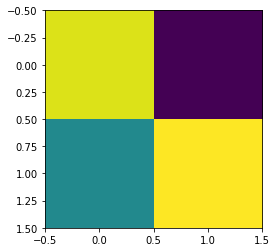

In [33]:
plt.imshow(cl.Acoef_)

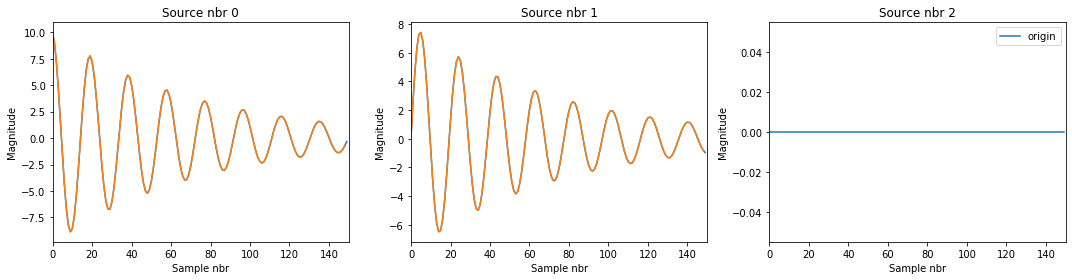

In [23]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p - 1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()

# Example 2: iSDR order 2

In [24]:
G_2 = np.zeros((n_c, n_s*2))
G_2[:, n_s:] = np.dot(G, A)
cl = ciSDR.linear_model.iSDR(l21_ratio=1e-10, la=1e-3, tol=1e-12, max_iter=10000)
m_p = 3
Atmp = np.zeros((n_s, n_s*m_p))
Atmp[:, -n_s:] = np.eye(n_s)
cl.solver(G, M, SC, nbr_iter=10, model_p=m_p, A=Atmp, method='lasso')
R = cl.coef_

Iteration 0: nbr of active sources 3
Iteration 1: nbr of active sources 2


/home/bbelaouc/Wokspace/iSDR_cython/src/iSDR_cython/linear_model.py:94: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37435953836490415, tolerance: 1.499556466714007e-08
  check_random_state(self.random_state), random)


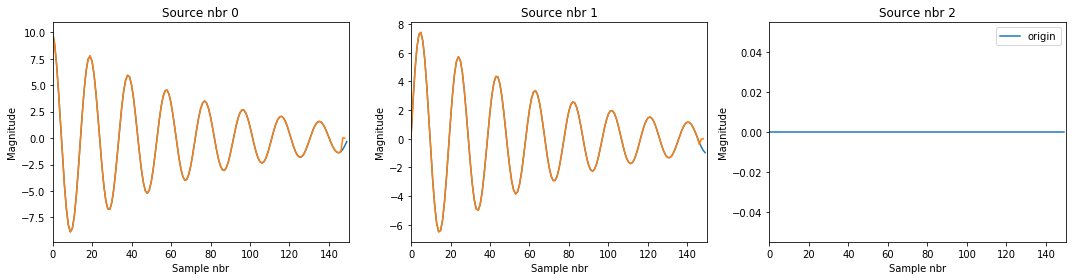

In [25]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p - 1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()

In [26]:
for i in range(m_p, n_t):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

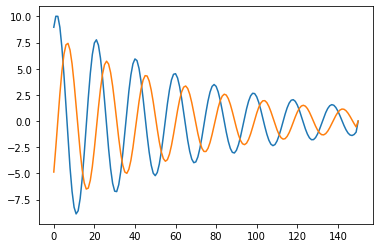

In [27]:
plt.plot(R.T)

In [28]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.934961,0.314237
eig_1,0.934961,-0.314237
eig_2,-0.226969,0.963741
eig_3,-0.226969,-0.963741
eig_4,-0.702525,0.649551
eig_5,-0.702525,-0.649551


In [29]:
cl.eigs

,real,imag
eig,,
eig_0,0.934961,0.314237
eig_1,0.934961,-0.314237
eig_2,-0.226969,0.963741
eig_3,-0.226969,-0.963741
eig_4,-0.702525,0.649551
eig_5,-0.702525,-0.649551


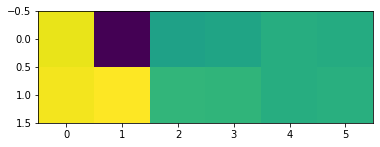

In [12]:
plt.imshow(cl.Acoef_)

In [ ]:
SC

In [14]:
cl.coef_.shape

(2, 151)

In [15]:
M.shape

(3, 149)